# Nonlinear curve-fitting with scipy.optimize

Problems from:
- _Introduction to Python for Science and Engineering_, David J. Pine, and
- Jon Aurnou for UCLA EPSS 171, Advanced Computing in Python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.io as sio

## (1) Pine Chapter 8 #6
_fitting an oscillating decay function_

##### (a) Define function and make starting guesses for fit

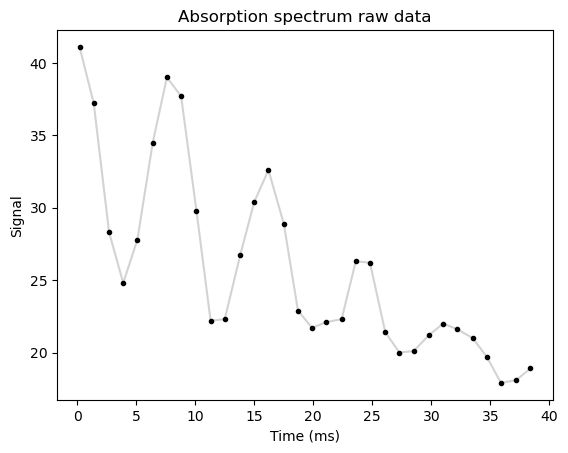

In [5]:
# plot raw data
data = np.loadtxt('Pine_ch8_ex6_data.txt', skiprows = 4)
t, a, da = data.T

plt.plot(t, a, '-', color = 'lightgray')
plt.plot(t, a, '.', color = 'k')
plt.title('Absorption spectrum raw data')
plt.xlabel('Time (ms)')
plt.ylabel('Signal');

In [6]:
# general decaying oscillating function d(t)
def oscdecay(t, A, B, C, tau, omega):
    
    return A*(1+B*np.cos(omega*t))*np.exp(-np.square(t)/(2*tau**2)) + C

# starting values for scipy.optimize
guesses = [10, 2, 15, 3, 1]

##### (b) Fit the data, calculate reduced $\chi^2$, and make a plot

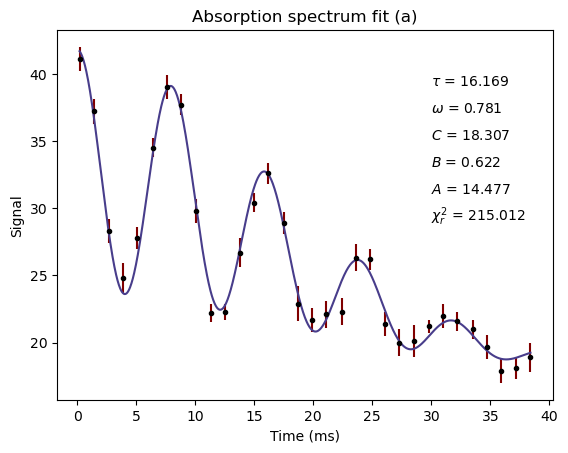

In [8]:
# do the nonlinear fit
params, covar = opt.curve_fit(oscdecay, t, a, p0 = guesses, sigma = da)

# unpack parameters
A, B, C, tau, omega = params
params = params.tolist()

# reduced chi-squared
def rchisq_fn(fn, y, dy, n):
    resid = y - fn
    rchisq = ((resid/dy)**2).sum() / ( len(y) - n )
    return rchisq

rchisq = rchisq_fn(oscdecay(t, *guesses), a, da, len(params))

# create best fit curve
xfit = np.linspace(min(t), max(t), 1000)
yfit = oscdecay(xfit, A, B, C, tau, omega)

# plot
plt.errorbar(t, a, da, fmt = '.', color = 'k', ecolor = 'maroon')
plt.plot(xfit, yfit, '-', color = 'darkslateblue')
plt.title('Absorption spectrum fit (a)');

def oscd_labels(rchisq, A, B, C, omega, tau):
    plt.xlabel('Time (ms)')
    plt.ylabel('Signal')
    txtloc = np.linspace(max(a) - 12, max(a) - 2, 6)
    txt = ('$\\chi^2_r$ = {0:0.3f}', '$A$ = {0:0.3f}', '$B$ = {0:0.3f}', '$C$ = {0:0.3f}', '$\\omega$ = {0:0.3f}', '$\\tau$ = {0:0.3f}') 
    vals = (rchisq, A, B, C, omega, tau)
    [plt.text(30, txtloc[i], txt[i].format(vals[i])) for i in range(len(vals))]

oscd_labels(rchisq, A, B, C, omega, tau)

#plt.savefig('HW4_P1b_Campos.png', dpi = 300)

##### (c) $3\omega$ plot

Use optimal values as guesses for $A, B, C, \tau$, and use optimal value $\times  3$ for $\omega$

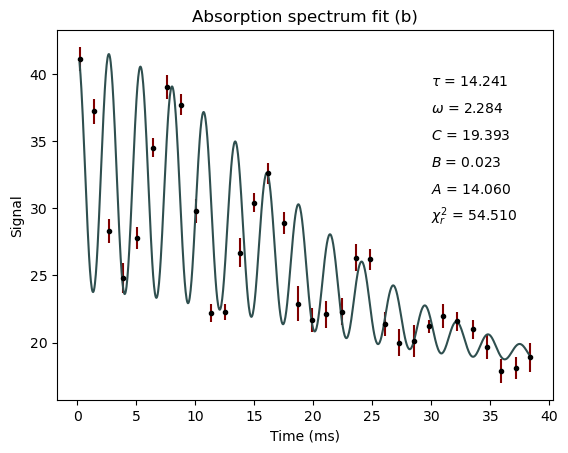

In [10]:
# do the nonlinear fit
guesses2 = [A, B, C, tau, 3*omega]
params2, covar = opt.curve_fit(oscdecay, t, a, p0 = guesses2, sigma = da)
A2, B2, C2, tau2, omega2 = params2

# reduced chi-squared
rchisq2 = rchisq_fn(oscdecay(t, *guesses2), a, da, len(guesses2))

# create best fit curve
yfit2 = oscdecay(xfit, *params2)

# plot
plt.errorbar(t, a, da, fmt = '.', color = 'k', ecolor = 'maroon');
plt.plot(xfit, oscdecay(xfit, *guesses2), color = 'darkslategrey')
plt.title('Absorption spectrum fit (b)')
oscd_labels(rchisq2, A2, B2, C2, omega2, tau2)

#plt.savefig('HW4_P1c_Campos.png', dpi = 300)

##### (d) $\chi_r^2$ as a function of $\omega$

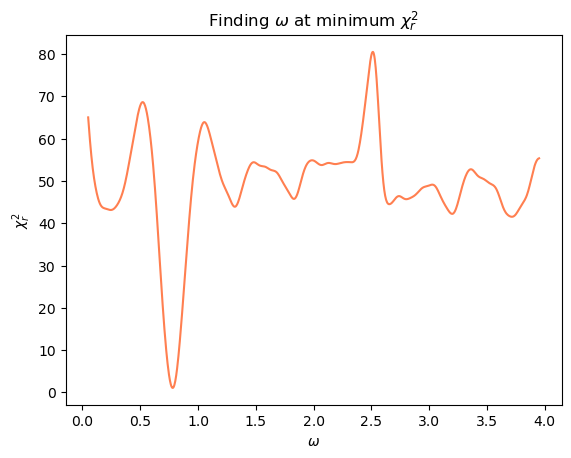

In [12]:
# calculate red chi sq. for omegas over the range [.05, 3.95]
omegas = np.linspace(.05, 3.95, 1000)
rchisqs = np.zeros(len(omegas))

for i in range(len(omegas)):
    guesses3 = [A, B, C, tau, omegas[i]]
    rchisqs[i] = rchisq_fn(oscdecay(t, *guesses3), a, da, len(guesses3))

plt.plot(omegas, rchisqs, '-', color = 'coral')
plt.xlabel('$\\omega$')
plt.ylabel('$\\chi_r^2$')
plt.title('Finding $\\omega$ at minimum $\\chi_r^2$');

#plt.savefig('HW4_P1d_Campos.png', dpi = 300)

## (2) Earthquake arrival
_locate earthquake arrival time by fitting the following piecewise function to waveform data:_

$$y=\begin{equation}
\left\{ 
  \begin{aligned}
    y = (t - t_0)sin(k(t-t_0)) + \phi, \ \qquad t > = t_0\\\
    y = 0, \quad \qquad t < t_0 \quad\\
  \end{aligned}
  \right.
\end{equation}
$$

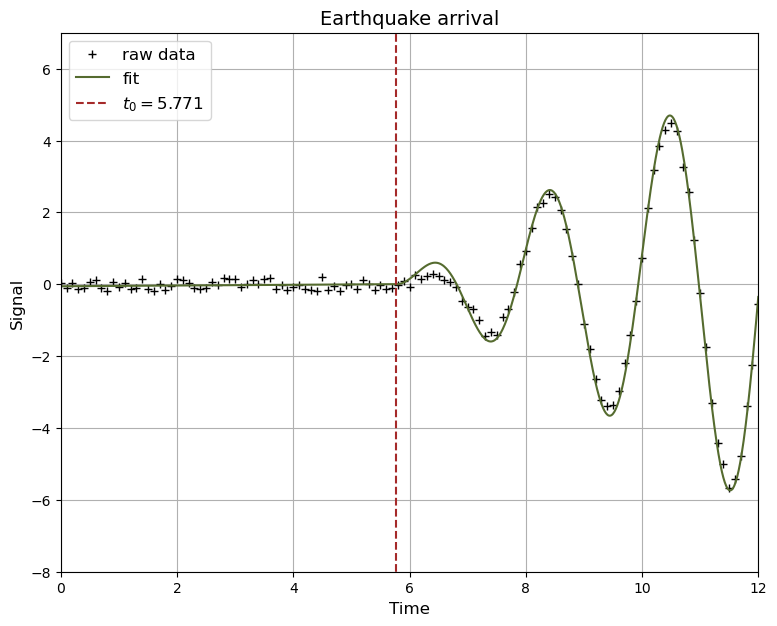

In [14]:
# load data
data = sio.loadmat('DATA_EQarrival.mat', squeeze_me = True)
t = data['t']
y = data['y']

# function for arrival equation above
def EQ_func(t, t0, k, phi):
    '''
    Piecewise graph of earthquake signal.
    No signal until t0 (arrival), then the signal is a sinusoid.
    '''
    return np.piecewise(t, [t < t0], [lambda t:(t-t0)*np.sin(phi), lambda t:(t-t0)*np.sin(k*(t-t0) + phi)])
       
# do the nonlinear fit
guesses = [6, 2.8, 0]
params, covar = opt.curve_fit(EQ_func, t, y, p0 = guesses, sigma = None)
t0, k, phi = params

# best fit curve
xfit = np.linspace(0,12,1000)
yfit = EQ_func(xfit, t0, k, phi)

# plot
plt.figure(1, figsize = (9,7))
plt.xlim(0,12)
plt.ylim(-8,7);
plt.grid()
plt.plot(t, y, '+k', markersize = 6, label = 'raw data')               
plt.plot(xfit, yfit, color = 'darkolivegreen', label = 'fit');    

# plot vertical line at t = t0
yline = np.linspace(-10, 10, 1000)
tline = t0 * np.ones(len(yline))
plt.plot(tline, yline, '--', color = 'brown', label = '$t_0 = $'+ str(round(t0,3)))

# labels
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Signal', fontsize = 12)
plt.title('Earthquake arrival', fontsize = 14)
plt.legend(loc = 2, fontsize = 12);

#plt.savefig('HW4_P2_Campos.png', dpi = 300)

## (3) Fitting the sum of two sines
_Fit the function_

$$y = \sin(\omega_1x) + \sin(\omega_2x)$$


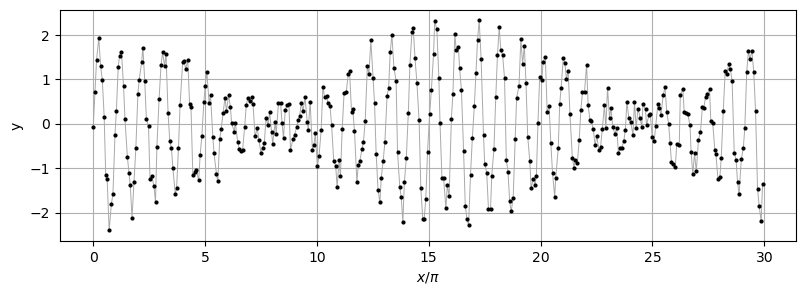

In [16]:
# plot raw data
data = sio.loadmat('Prob3_Data.mat', squeeze_me = True)
x = data['x_noisy']
y = data['y_noisy']

plt.figure(figsize = (9.5, 3))
plt.plot(x/np.pi, y, '-', color = 'darkgray', linewidth = .7)
plt.plot(x/np.pi, y, '.k', markersize = 4)
plt.xlabel('$x/\\pi$')
plt.ylabel('y')
plt.grid()

In [17]:
# make an initial guess for one of the frequencies
guess_init = 1

# will use L2 norm as error to minimize
def L2norm(fn, y):
    return ((fn - y)**2).sum()

# will fit this function:
def addedsines(x, freq1, freq2):
    return np.sin(freq1*x) + np.sin(freq2*x)

def freq_opt(fn, freq1, x, y):
    ''' Get optimal freq2 given freq1 '''
    guess_range = np.linspace(1, 3, 100)
    freqs = []
    norms = []
    
    for guess in guess_range: 
        guesses = [freq1, guess]
        params, covar = opt.curve_fit(fn, x, y, p0 = guesses, maxfev = 5000)
        freqs.append(params[1])
        norms.append(L2norm(fn(x, *params), y))
    
    idx = np.where(norms == min(norms))[0][0]
    return freqs[idx]

# find freq2 based on an initial guess of freq1 = 2, then use freq2 to re-guess freq1
best_freq1 = freq_opt(addedsines, guess_init, x, y)
best_freq2 = freq_opt(addedsines, best_freq1, x, y)

# fit curves
xfit = np.linspace(min(x), max(x), 1000)
yfit1 = addedsines(xfit, guess_init, best_freq1)
yfit2 = addedsines(xfit, best_freq1, best_freq2)

# L2s for comparison
error1 = L2norm(addedsines(x, guess_init, best_freq1), y)
error2 = L2norm(addedsines(x, best_freq1, best_freq2), y) 

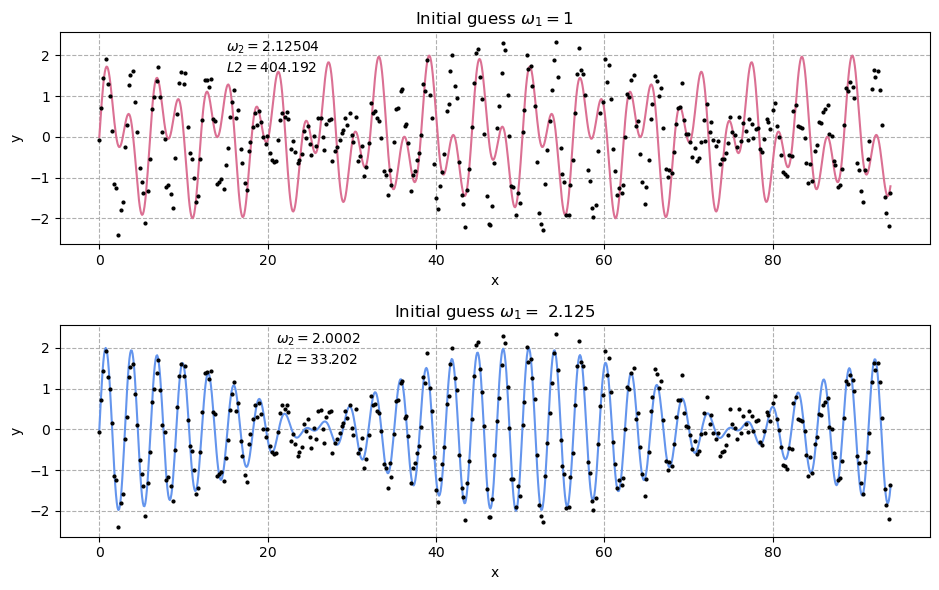

In [25]:
# plots
plt.figure(2, figsize = (9.5, 6))

plt.subplot(2,1,1)
plt.plot(xfit, yfit1, 'palevioletred')
plt.plot(x, y, '.k', markersize = 4)
plt.title('Initial guess $\\omega_1 = $' + str(guess_init))
plt.xlabel('x')
plt.ylabel('y')
plt.text(15, 2.1, '$\\omega_2 = $'+ str(round(best_freq1, 5)))
plt.text(15, 1.6, '$L2 = $'+ str(round(error1,3)))
plt.grid(linestyle = '--')

plt.subplot(2,1,2)
plt.plot(xfit, yfit2, 'cornflowerblue')
plt.plot(x, y, '.k', markersize = 4)
plt.title('Initial guess $\\omega_1 = $ ' + str(round(best_freq1, 3)))
plt.xlabel('x')
plt.ylabel('y')
plt.text(21, 2.1, '$\\omega_2 = $'+ str(round(best_freq2, 5)))
plt.text(21, 1.6, '$L2 = $'+ str(round(error2,3)))
plt.grid(linestyle = '--')

plt.tight_layout()
#plt.savefig('HW4_P3_Campos.png', dpi = 300)

If we repeat the process one more time, we get a smaller improvement in L2, and a much smaller improvement in the frequency (comparing 1st & 3rd times): 
1st time: 
	omega2 = 2.1250 
	L2 = 404.2
2nd time: 
	omega2 = 2.0002 
	L2 = 33.2
3rd time: 
	omega2 = 2.1232 
	L2 = 31.3


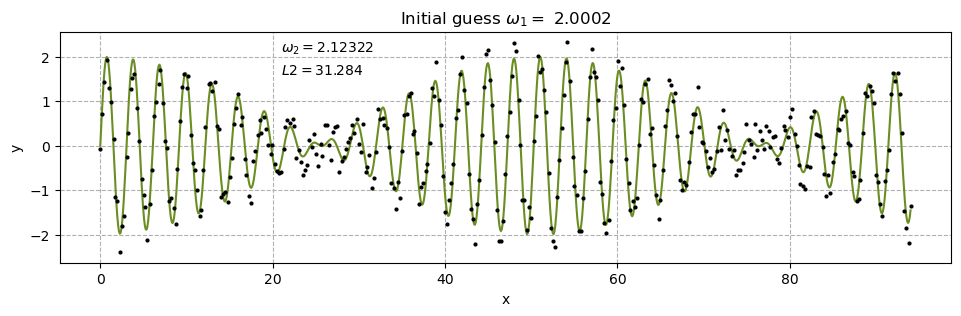

In [27]:
# analysis & checking
print('If we repeat the process one more time, we get a smaller improvement in L2, and a much smaller improvement in the frequency (comparing 1st & 3rd times): ')

best_freq3 = freq_opt(addedsines, best_freq2, x, y)
yfit3 = addedsines(xfit, best_freq2, best_freq3)
error3 = L2norm(addedsines(x, best_freq2, best_freq3), y)

print('1st time: \n\tomega2 = {0:.4f} \n\tL2 = {1:.1f}'.format(best_freq1, error1))
print('2nd time: \n\tomega2 = {0:.4f} \n\tL2 = {1:.1f}'.format(best_freq2, error2))
print('3rd time: \n\tomega2 = {0:.4f} \n\tL2 = {1:.1f}'.format(best_freq3, error3))

plt.figure(figsize = (11.5, 3))
plt.plot(xfit, yfit3, 'olivedrab')
plt.plot(x, y, '.k', markersize = 4)
plt.title('Initial guess $\\omega_1 = $ ' + str(round(best_freq2, 5)))
plt.xlabel('x')
plt.ylabel('y')
plt.text(21, 2.1, '$\\omega_2 = $'+ str(round(best_freq3, 5)))
plt.text(21, 1.6, '$L2 = $'+ str(round(error3,3)))
plt.grid(linestyle = '--')

In [29]:
print('\nBecause this improvement is small, we can predict that running this a 4th time will give us a frequency very close to 2.0002 and error close to 31.3 (and we could do this/loop it if we needed more precision).')
print('\nSo our two frequencies are approximately 2.1 and 2.0.')


Because this improvement is small, we can predict that running this a 4th time will give us a frequency very close to 2.0002 and error close to 31.3 (and we could do this/loop it if we needed more precision).

So our two frequencies are approximately 2.1 and 2.0.
